In [47]:
# 导包
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
from skimage import filters
from scipy.signal import lfilter
from PIL import Image 
import pandas as pd 
%matplotlib inline

plt.rcParams['font.sans-serif'] = 'SimHei'  # 设置中文字体
plt.rcParams['axes.unicode_minus'] = False  # 设置正常显示负号

In [68]:
del_78 = True

crop_root = 'train_2crop'
imgs = os.listdir(crop_root)
if del_78:
    imgs = [i for i in imgs if '78-2' not in i]
imgs = sorted(imgs,key = lambda i : int(i.split('-')[0]))
hsv_means = []
for img_name in imgs:
    img_path = os.path.join(crop_root,img_name)
    img = plt.imread(img_path)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    hsv = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    h = hsv[:,:,0]
    
    thresh = filters.threshold_otsu(gray)
    mask = (gray>=thresh)*1
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    mask_green = cv2.erode(mask.astype(np.float), kernel)   # 开运算
    
    for i in range(3):
        hsv[...,i] = hsv[...,i]*mask_green
#         img[...,i] = img[...,i]*mask_green
    hsv_mean = hsv[mask_green.astype(np.bool)].mean(axis = 0)
    hsv_means.append(hsv_mean)
    print(img_name,' & ',' & '.join([str(i) for i in np.round(hsv_mean,1)]),'\\\\')
hsv_min = np.min(hsv_means,axis = 0)
hsv_max = np.max(hsv_means,axis = 0)
print('最小值，最大值')
print(hsv_min)
print(hsv_max)

71-2.bmp  &  39.2 & 230.7 & 71.6 \\
72-2.bmp  &  35.2 & 239.4 & 69.6 \\
74-2.bmp  &  29.9 & 224.2 & 255.0 \\
76-2.bmp  &  28.4 & 145.2 & 69.0 \\
85-2.bmp  &  39.0 & 253.9 & 88.3 \\
101-2.bmp  &  58.2 & 208.5 & 236.9 \\
102-2.bmp  &  35.9 & 163.1 & 62.7 \\
106-2.bmp  &  31.6 & 246.6 & 66.3 \\
122-2.bmp  &  45.6 & 202.8 & 155.0 \\
123-2.bmp  &  38.0 & 251.5 & 179.5 \\
127-2.bmp  &  23.4 & 244.6 & 84.9 \\
133-2.bmp  &  34.3 & 241.6 & 66.8 \\
250-2.bmp  &  21.0 & 252.5 & 93.6 \\
284-2.bmp  &  29.9 & 142.2 & 74.3 \\
324-2.jpg  &  55.1 & 106.1 & 91.4 \\
325-2.jpg  &  51.5 & 168.7 & 92.7 \\
327-2.jpg  &  71.5 & 108.2 & 180.7 \\
329-2.jpg  &  44.3 & 242.7 & 86.6 \\
330-2.jpg  &  40.3 & 240.8 & 186.6 \\
331-2.jpg  &  48.5 & 235.1 & 94.6 \\
335-2.jpg  &  63.0 & 82.1 & 178.5 \\
337-2.jpg  &  66.9 & 91.6 & 73.8 \\
338-2.jpg  &  59.7 & 127.5 & 58.7 \\
339-2.jpg  &  68.1 & 162.2 & 157.6 \\
340-2.jpg  &  58.0 & 166.2 & 155.3 \\
341-2.jpg  &  42.4 & 225.3 & 195.6 \\
342-2.jpg  &  53.0 & 109.7 & 104.3 

In [64]:
# 读取图片
root_2 = 'train_2'
img_names = os.listdir(root_2)
img_names = sorted(img_names,key = lambda name : int(name.split('-')[0])) # 按顺序读取图片

### 经过肉眼筛查，以4-2.bmp为例，有个黄绿光像素的HSV值为48,138,32，输出lower_green，upper_green作对比 

133-2.bmp误差较大

In [65]:
H_change = [hsv_min[0],hsv_max[0]]
S_change = [hsv_min[1],hsv_max[1]]
V_change = [hsv_min[2],hsv_max[2]]

In [66]:
def seg_mode(img=None, img_name=None):
    if img is not None:# 待设计识别模式
        pass
    elif img_name is not None:
        if img_name.split('.')[-1] == 'jpg':
            return 'center'
        else:
            return 'all'
        
# https://blog.csdn.net/weixin_42009479/article/details/105812705
N = 5000
b = 0.5

def max_min_value_filter(image, ksize=3, mode=1):# 最小值滤波的卷积核
    img = image.copy()
    rows, cols = img.shape
    # if channels == 3:
    #     img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    padding = (ksize-1) // 2
    new_img = cv2.copyMakeBorder(img, padding, padding, padding, padding, cv2.BORDER_CONSTANT, value=1)
    for i in range(rows):
        for j in range(cols):
            roi_img = new_img[i:i+ksize, j:j+ksize].copy()
            min_val, max_val, min_index, max_index = cv2.minMaxLoc(roi_img)
            if mode == 1:
                img[i, j] = max_val
            elif mode == 2:
                img[i, j] = min_val
            else:
                raise Exception("please Select a Mode: max(1) or min(2)")

    return img


def movingthreshold(f, n, k):
    shape = f.shape
    assert n >= 1
    assert 0 < k < 1
    f[1:-1:2, :] = np.fliplr(f[1:-1:2, :])
    f = f.flatten()
    maf = np.ones(n) / n
    res_filter = lfilter(maf, 1, f)
    g = np.array(f > k * res_filter).astype(int)
    g = g.reshape(shape)
    g[1:-1:2, :] = np.fliplr(g[1:-1:2, :])
    return g

def iter_gauss(img,ksize=55,sigma=35,g_t = 0.3,iter_num = 5):
    for i in range(iter_num):
        img = cv2.GaussianBlur(img,(ksize,ksize),sigma)
        img[img>g_t]=1
    img[img<=g_t] = 0
    return img

def seg_stone(gray):
    # 移动平均阈值

    gray_mt = 1-movingthreshold(gray,1*gray.shape[1],0.4)
    gray_mt = cv2.GaussianBlur(gray_mt.astype(np.float),(5,5),5)
    gray_mt_before = gray_mt.copy()
    gray_mt[:50,60:170][gray_mt[:50,60:170]<gray_mt[gray_mt>0].mean()] = 0
    gray_mt[175:,60:170][gray_mt[175:,60:170]<gray_mt[gray_mt>0].mean()] = 0
    gray_mt = (gray_mt>0.4*gray_mt.mean())*1    
    # 最大滤波
    g_max = max_min_value_filter(gray_mt,3,1)
    g_max = cv2.blur(g_max,(3,3))

    # 形态学闭运算
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))  
    morph_img =cv2.morphologyEx(gray_mt.astype(np.float)
                                ,cv2.MORPH_CLOSE,kernel) 

    # 形态学开运算
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))  
    morph_img =cv2.morphologyEx(morph_img.astype(np.float)
                                ,cv2.MORPH_OPEN,kernel) 
    mask = morph_img
    # 迭代高斯滤波
    mask = iter_gauss(morph_img,ksize = 3,sigma = 1)
    return mask#, gray_mt, gray_mt_before,g_max

def seg_hsv(img):# 输入：BGR图像
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    # 定义HSV中荧光绿的范围
    lower_green_change = np.array([H_change[0], S_change[0], V_change[0]])
    upper_green_change = np.array([H_change[1], S_change[1], V_change[1]])

    # 对HSV图像进行阈值处理，得到荧光绿的范围
    mask_green_change = cv2.inRange(hsv, lower_green_change, upper_green_change)

    mask_green_color = mask_green_change.copy()
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    mask_green_change = cv2.morphologyEx(mask_green_change, cv2.MORPH_CLOSE, kernel)  # 闭运算
    return mask_green_change/255

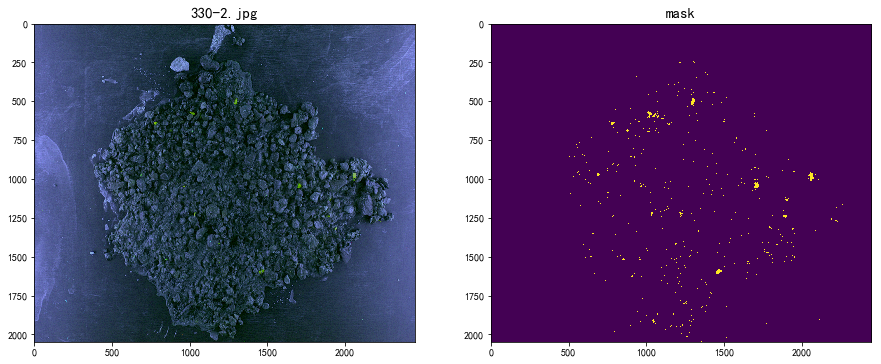

330 & 23021 & 2159618 & 1.07% \\


In [67]:
percs = []
img_names = ['330-2.jpg']
for i in range(len(img_names)): 
#     if i<300:
#         continue 
    imgs = os.path.join(root_2,img_names[i])
    segmentation_mode = seg_mode(img_name = imgs)
    img = cv2.imread('./'+imgs )
    if segmentation_mode == 'center':
        img_temp = Image.fromarray(img).resize((224,224))
        img_temp = np.asarray(img_temp)
        # 灰度图
        gray = cv2.cvtColor(img_temp,cv2.COLOR_BGR2GRAY)
        
        mask = seg_stone(gray)
        mask = Image.fromarray(mask).resize(img.shape[:-1][::-1])
        mask = np.array(mask)
        
    elif segmentation_mode == 'all':
        mask = np.ones(img.shape[:-1])
        
#     img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    mask_green = seg_hsv(img)

    ary = np.asarray(mask_green)
    sum_ary = np.sum(mask)
    sum_1 = np.sum(ary)
    perc = sum_1 / sum_ary

    percs.append(perc)
    
    plt.figure(figsize = (15,8))
    plt.subplot(121)
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    plt.title(img_names[i],fontsize = 15)
    plt.subplot(122)
    plt.imshow(mask_green)
    plt.title('mask',fontsize = 15)
    if del_78:
        plt.savefig('../latex/fig/含油像素分割结果330_del78.png',dpi = 200,bbox_inches = 'tight')
    else:
        plt.savefig('../latex/fig/含油像素分割结果330.png',dpi = 200,bbox_inches = 'tight')
    plt.show()

#     print('石头大小：', sum_ary)
#     print('求和：', sum_1)
#     print('百分比：', perc)
    code_id = int(os.path.split(imgs)[-1].split('-')[0])
    print('{} & {} & {} & {:.2f}% \\\\'.format(code_id,int(sum_1),int(sum_ary),perc*100))

In [26]:
df = pd.read_csv('第二问结果.csv',encoding = 'gbk')
for i in range(len(img_names)):    
    img_id = int(img_names[i].split('-')[0])
    df['含油面积百分含量'][df['样本编号']==img_id] = str(percs[i]*100)+'%'
df.to_csv('第二问结果.csv',encoding = 'gbk',index = None)

d:\other_all\application\python\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


# 实验

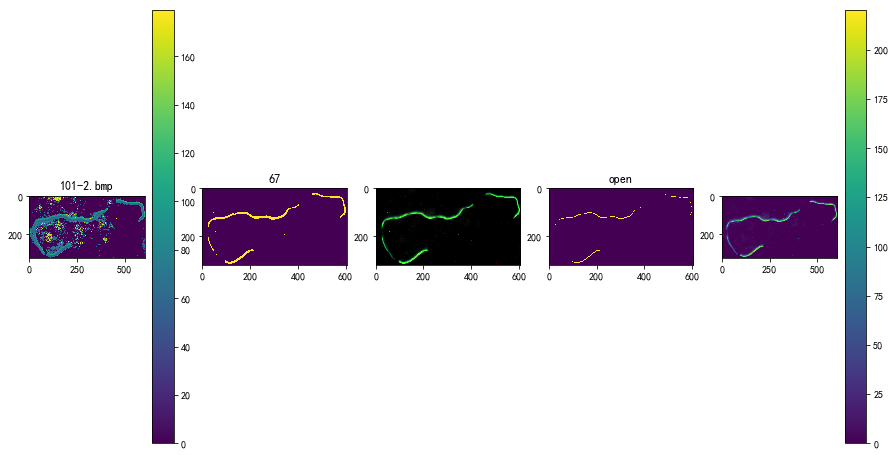

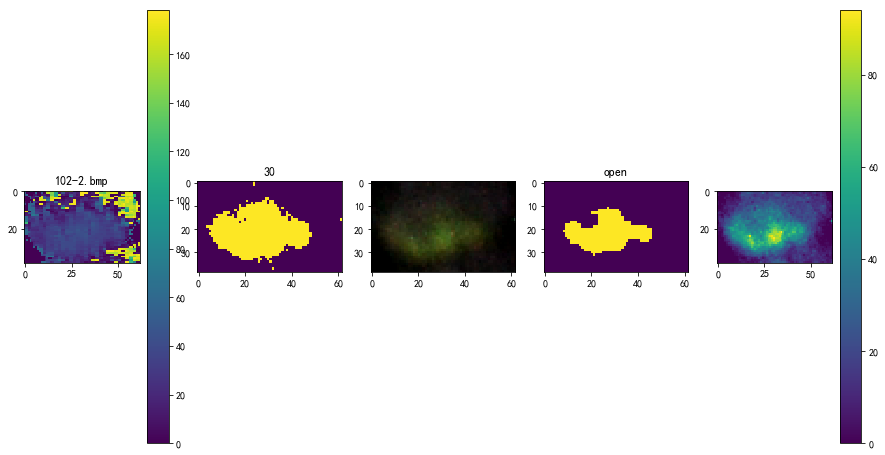

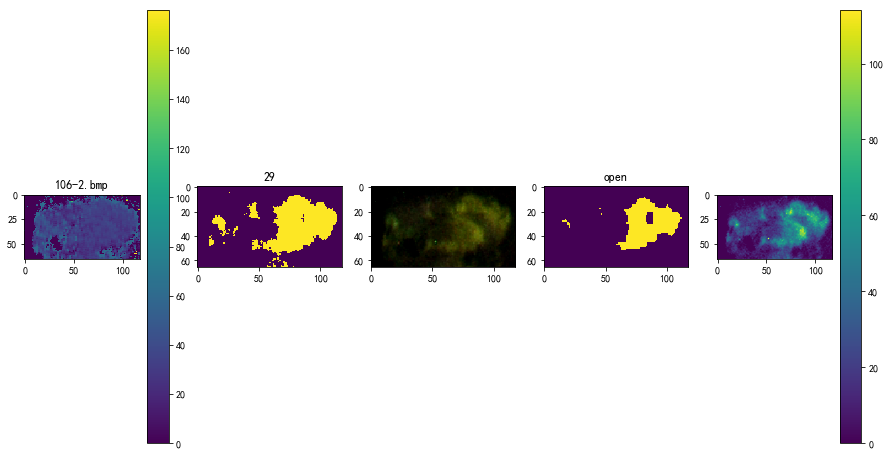

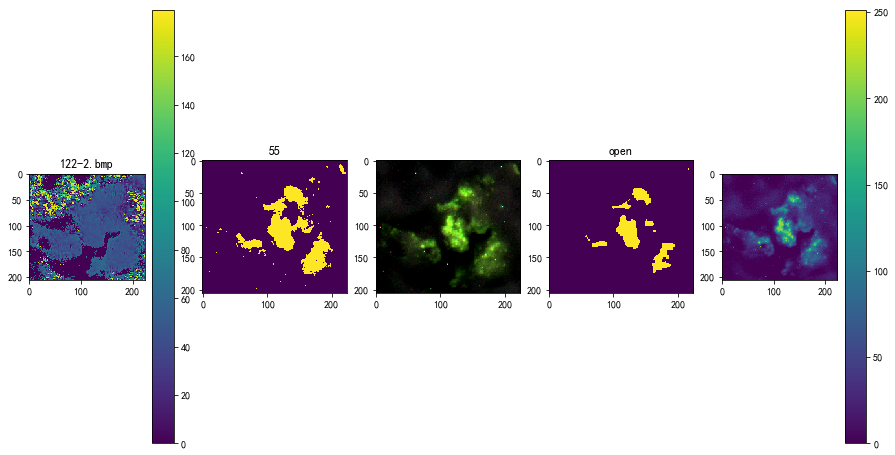

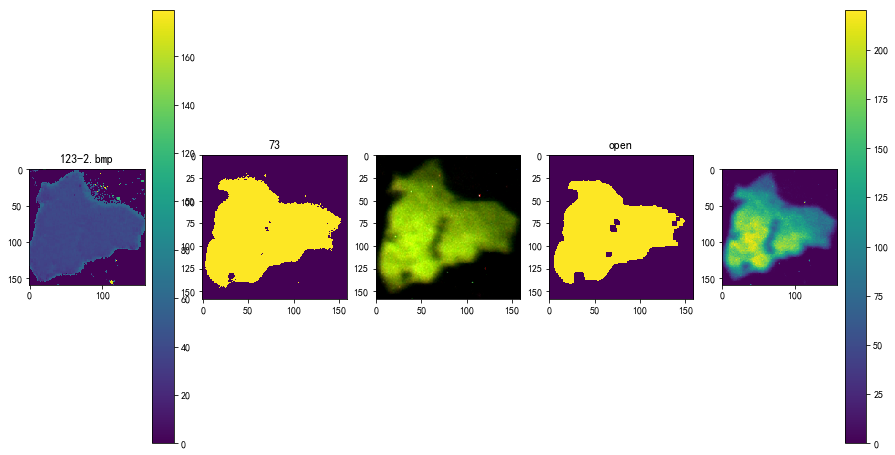

KeyboardInterrupt: 

In [6]:
crop_root = 'train_2crop'
imgs = os.listdir(crop_root)
for img_name in imgs:
    img_path = os.path.join(crop_root,img_name)
    img = plt.imread(img_path)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    hsv = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    h = hsv[:,:,0]
    
    thresh = filters.threshold_otsu(gray)
    mask = (gray>=thresh)*1
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    mask_green = cv2.erode(mask.astype(np.float), kernel)   # 开运算
    plt.figure(figsize = (15,8))
    plt.subplot(151)
    plt.imshow(h)
    plt.title(img_name)
    plt.colorbar()
    plt.subplot(152)
    plt.imshow(mask)
    plt.title(thresh)
    plt.subplot(153)
    plt.imshow(img)
    plt.subplot(154)
    plt.imshow(mask_green)
    plt.title('open')
    plt.subplot(155)
    plt.imshow(gray)
    plt.colorbar()
    plt.show()

In [ ]:
import requests as rq 
from lxml import etree
f = open('颜色.html',encoding = 'utf-8')
t = f.read()
f.close()
html = etree.HTML(t)
color_16 = html.xpath('//*[@id="color"]/tr/td[4]//text()')
print(color_16)

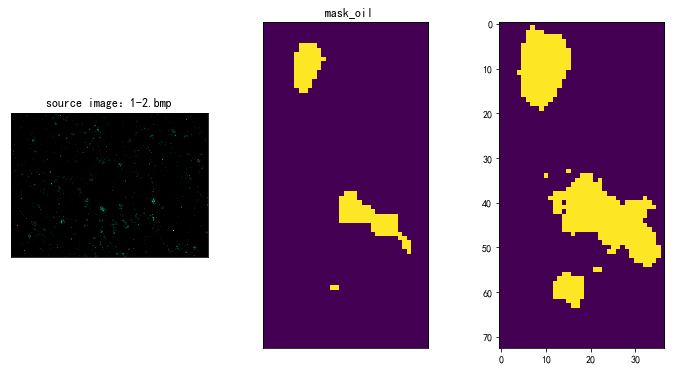

TypeError: append() takes exactly one argument (0 given)

In [9]:
percs = []
for i in range(len(img_names)):
#     if i<300:
#         continue
    imgs = os.path.join(root_2,img_names[i])
    img = cv2.imread('./'+ imgs )

    # 将 BGR 模式转换为 HSV 模式
    
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    # 定义HSV中荧光绿的范围
    lower_green_change = np.array([H_change[0], S_change[0], V_change[0]])
    upper_green_change = np.array([H_change[1], S_change[1], V_change[1]])

    # 对HSV图像进行阈值处理，得到荧光绿的范围
    mask_green_change = cv2.inRange(hsv, lower_green_change, upper_green_change)

    mask_green_color = mask_green_change.copy()
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    mask_green_change = cv2.morphologyEx(mask_green_change, cv2.MORPH_CLOSE, kernel)  # 闭运算
#     mask_green_change = cv2.m.orphologyEx(mask_green_change, cv2.MORPH_OPEN, kernel)   # 开运算
    
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
    fig = plt.figure(figsize=(12,6)) 
    plt.subplot(131), plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    plt.title("source image：" + img_names[i]), plt.xticks([]), plt.yticks([])
    
    plt.subplot(132), plt.imshow(mask_green)
    plt.title(" mask_oil"), plt.xticks([]), plt.yticks([])
    
    plt.subplot(133)
    plt.imshow(mask.astype(np.int))
    plt.show()
    
    percs.append()